In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# sys.path.append('D:\Jupyter_Home\(L)훈련소스\노후투자\lib')
sys.path.append('../lib')
import my_function as my

### 투자종목 구분

In [10]:
li_fam = ['대한항공']
li_my = [] # '대한항공'
li_sj = []
invest_grp = [li_fam, li_my]

### (KOSPI업데이트 후) 평가 누락일 있나 살펴보기

In [11]:
target = my.get_missingShotDay_ByKospi()

if len(target) == 0: # 당일 or 휴일전 마지막 영업일은 재실행을 위해 무조건 포함
    target = pd.DataFrame(columns=['일자','지수','총평가액'])
    recently = my.get_mPrice_byCrwl('KOSPI',1)
    recently_day = recently.index[0]
    recently_kospi = recently['KOSPI'][0]
    target.loc[0] = [recently_day, recently_kospi, 0] 
target

,일자,지수,yyyymm,총평가액
0,2021-03-24,2995.63,NaN,NaN
1,2021-03-24,2994.53,2021-03,NaN


## 당일에 한해 변경사항 있을 시 세팅 조정

In [12]:
new_rp = -1
add_invest = -1

yyyymm = '202006'
li_sheet= ['future','fam','me']

### ★대상일 돌며 평가 및 Shot(당일 기본 포함) 

In [13]:
today = pd.datetime.now().strftime('%Y-%m-%d')
today

'2021-03-24'

date: 2021-03-24

직전일 데이터 가져오기 :  2021-03-23  /  0 초
기준일 포트변동 없음 → 전일 결과포트로 구성 진행

대상포트 가져오기 :  0 초

포트 현재가로 평가하기 :  2 초

shot데이터준비 :  0 초
2021-03-24 2021-03-23 : 19103670.0

shot :  0 초

투자목적별 구분 :  0 초


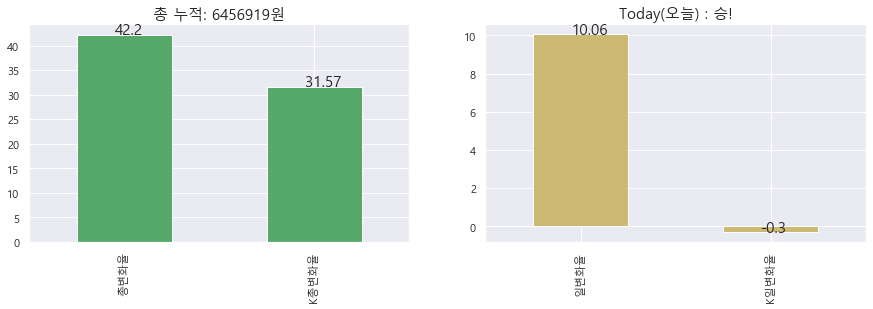

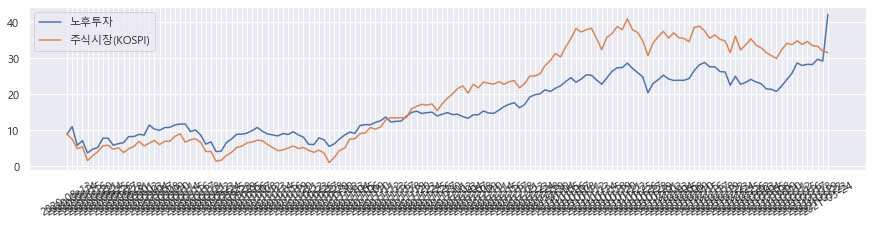


차트저장 :  19 초
date: 2021-03-24

직전일 데이터 가져오기 :  2021-03-23  /  0 초
기준일 포트변동 없음 → 전일 결과포트로 구성 진행

대상포트 가져오기 :  0 초

포트 현재가로 평가하기 :  2 초

shot데이터준비 :  0 초
2021-03-24 2021-03-23 : 19115530.0

shot :  0 초

투자목적별 구분 :  0 초


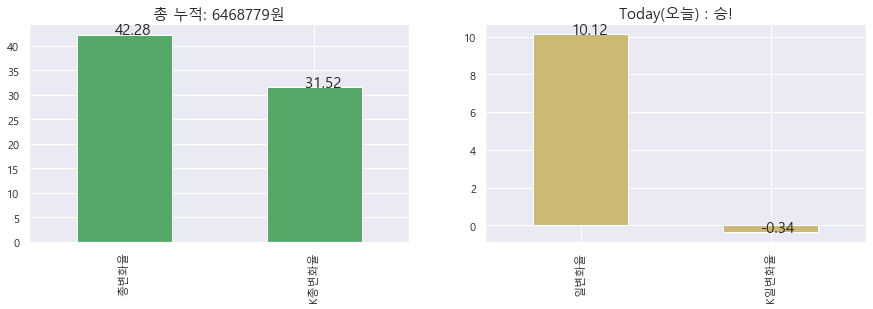

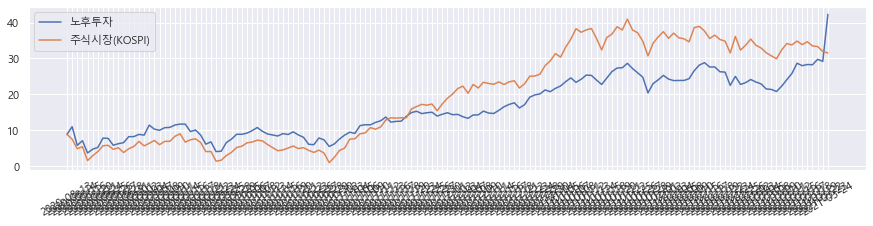


차트저장 :  18 초
149전 : 74승 72패 3무(승률: 49.7%)

노후손익 :  6468779 원

총수익률 차: 42.28  vs  31.52 [gap :10.76%]

Today : [승] 10.12  vs  -0.34  [gap :10.46%]

각종출력 :  0 초


,BM대비,KOSPI,투자원금,노후손익,일변화율,총변화율,K손익,K일변화율,K총변화율
일자,,,,,,,,,
2021-03-24,승,2994.53,15300000.0,6468779.0,10.12,42.28,4823242.0,-0.34,31.52


In [14]:
target = my.get_missingShotDay_ByKospi()

if len(target) == 0: # 당일 or 휴일전 마지막 영업일은 재실행을 위해 무조건 포함
    target = pd.DataFrame(columns=['일자','지수','총평가액'])
    recently = my.get_mPrice_byCrwl('KOSPI',1)
    recently_day = recently.index[0]
    recently_kospi = recently['KOSPI'][0]
    target.loc[0] = [recently_day, recently_kospi, 0] 


### 대상일 순환하면서 작업 : 현재  str 타입
for row in target[['일자','지수']].iterrows():
    save_cond = 0
    date = row[1]['일자']
    kospi = row[1]['지수']
    
    # 속도를 위해 당일 장마감 이후에만 shot, 파일저장, 차트저장 수행
    save_cond = (date !=today) | (pd.datetime.now().hour >= 16)

    s0 = pd.datetime.now()

    # 직전일 데이터를 기본 shot data 소스로 세팅
    shot_data = my.get_beforeDay_data_byShot(date)
    bf_day = shot_data['일자'] # 직전일
    shot_data['추가투자'] = 0
    
    #########################################
    # 신규투자 당일은 아래 열고 진행
    #########################################
    print("date:", date)
    if date == '2021-01-04':
        print("진입")
        save_cond = 1   # 세팅을 위해 파일엔 계속 찍어보기
        shot_data['추가투자'] = 900000
        shot_data['예수금'] =  2653249
    #########################################
    
    s1 = pd.datetime.now()-s0
    print("\n직전일 데이터 가져오기 : ", bf_day, " / ", s1.seconds,"초")

    # 대상포트 가져오기(매매변동 파일 있으면 신규구성, 없으면 전일파일로 구성)
    base_port = my.get_base_port(date, bf_day, li_sheet)
    s2 = pd.datetime.now()-s0-s1
    print("\n대상포트 가져오기 : ", s2.seconds,"초")
    
    # 포트를 기준일자 현재가로 평가 update
    eval_port = my.eval_port_byCrwl(base_port, date, 50)
    s3 = pd.datetime.now()-s0-s1-s2
    print("\n포트 현재가로 평가하기 : ", s3.seconds,"초")    
    
    # 누적수익률 shot 데이터 준비 후 shot !!
    shot_data['주식평가'] = eval_port[~eval_port['종목명'].isin(li_fam+li_my)]['평가금액'].sum() # [future] 주식pf합계
    if new_rp != -1 :
        shot_data['예수금'] = new_rp
    if add_invest != -1 :
        shot_data['추가투자'] = add_invest
    s4 = pd.datetime.now()-s0-s1-s2-s3
    print("\nshot데이터준비 : ", s4.seconds,"초")            

    shot = my.shot_today_byBeforeDay(date, shot_data, kospi, save_cond)
    print(date, bf_day, ":", shot_data['주식평가'] )
    s5 = pd.datetime.now()-s0-s1-s2-s3-s4
    print("\nshot : ", s5.seconds,"초")      
    
# ---------------------------------------------------------------------------------------------------------------------   
    # 투자목적별로 구분
    updated_fam = eval_port[eval_port['종목명'].isin(li_fam)]
    updated_me = eval_port[eval_port['종목명'].isin(li_my)]
    updated_future = eval_port[~eval_port['종목명'].isin(li_fam+li_my)]
    s6 = pd.datetime.now()-s0-s1-s2-s3-s4-s5
    print("\n투자목적별 구분 : ", s6.seconds,"초")          
    
    yyyymmdd = pd.to_datetime(date).strftime('%Y%m%d')
    if save_cond: 
        # 폴더 만들고 결과파일 생성/저장
        if not os.path.exists('일별현황//'+yyyymmdd):
            os.mkdir('일별현황//'+yyyymmdd)
        writer = pd.ExcelWriter('일별현황//'+yyyymmdd+'//port_histoty_'+yyyymmdd+'.xlsx', engine='openpyxl')
        my.excel_add_sheet(writer, updated_future, 'future')
        my.excel_add_sheet(writer, updated_fam, 'fam')
        my.excel_add_sheet(writer, updated_me, 'me')
        s7 = pd.datetime.now()-s0-s6
        print("\n폴더생성 / 결과파일저장 : ", s7.seconds,"초")          

    # 차트저장
    my.save_today_bar(shot, yyyymmdd,save_cond)
    my.save_total_and_kospi_chart(shot, yyyymmdd,save_cond)
    my.save_daily_bar(shot, yyyymmdd,save_cond)
    my.save_stock_barh(updated_future, yyyymmdd,save_cond)
    s8 = pd.datetime.now()-s0-s1-s2-s3-s4-s5-s6
    print("\n차트저장 : ", s8.seconds,"초")              

result_df = shot[['BM대비','KOSPI','투자원금','노후손익','일변화율','총변화율','K손익','K일변화율','K총변화율']]
result = result_df.tail(1).iloc[0]


win = len(shot['BM대비'][shot['BM대비']=='승'])
lose = len(shot['BM대비'][shot['BM대비']=='패'])
same = len(shot['BM대비'][shot['BM대비']=='무'])
win_rate = round(win/len(shot),2)*100

result_today = result_df.tail(1).iloc[0]
gap =( result['총변화율']-result['K총변화율'])
gap2 =( result['일변화율']-result['K일변화율'])

print("{}전 : {}승 {}패 {}무(승률: {}%)".format(len(shot), win, lose, same, round(win/len(shot)*100,1)))
print("\n노후손익 : ", int(result['노후손익']), "원")
print("\n총수익률 차: {}  vs  {} [gap :{}%]".format(result['총변화율'], result['K총변화율'], round(gap,2)))
print("\nToday : [{}] {}  vs  {}  [gap :{}%]".format(result['BM대비'], result['일변화율'], result['K일변화율'], round(gap2,2)))
s9 = pd.datetime.now()-s0-s1-s2-s3-s4-s5-s6-s8
print("\n각종출력 : ", s9.seconds,"초")         

result_df.tail(1)

### Fam

In [15]:
print("테마 평가손익 : ", int(updated_fam['평가손익'].sum()), '원')
# updated_fam['수익률'] = round(updated_fam['평가손익'] / updated_fam['매수금액']*100, 2)
updated_fam

테마 평가손익 :  0 원


,종목코드,종목명,매수가격,수량,매수금액,평가금액,현재가,평가손익,수익률


### 비즈원 데이터랑 수치 비교

In [16]:
print(int(eval_port['매수금액'].sum()),"|",int( eval_port['평가금액'].sum()),"|",int(eval_port['평가손익'].sum()),"|"
         ,round(int(eval_port['평가손익'].sum())/int(eval_port['매수금액'].sum())*100,2),"%")

13994414 | 19115530 | 5121116 | 36.59 %


### Future개별 성적

In [17]:
updated_future.sort_values('평가손익', ascending=False)

,종목코드,종목명,매수가격,수량,매수금액,평가금액,현재가,평가손익,수익률
0,000990,DB하이텍,20937.0,24.0,502500.0,1327200.0,55300.0,824700.0,164.12
22,268280,미원에스씨,76883.0,6.0,461300.0,1095000.0,182500.0,633700.0,137.37
18,195870,해성디에스,18000.0,28.0,504000.0,929600.0,33200.0,425600.0,84.44
21,248170,샘표식품,27015.0,19.0,513300.0,897750.0,47250.0,384450.0,74.90
9,035150,백산,5600.0,89.0,498400.0,875760.0,9840.0,377360.0,75.71
23,281820,케이씨텍,16437.0,31.0,509571.0,854050.0,27550.0,344479.0,67.60
14,134380,미원화학,45918.0,11.0,505100.0,825000.0,75000.0,319900.0,63.33
24,157490,TIGER 소프트웨어,14320.0,105.0,1503600.0,1769250.0,16850.0,265650.0,17.67
17,161000,애경유화,7379.0,68.0,501803.0,734400.0,10800.0,232597.0,46.35
13,120030,조선선재,83287.0,8.0,666300.0,896000.0,112000.0,229700.0,34.47
